Learning to predict shape evolution of liquid droplets at the air-ferrofluid interface due to sequential actuations

Author: P. A. Diluka Harischandra

In [1]:
import glob as glob
import numpy as np
import time
import xarray as xr

from Sequence_Data_Tools import *

path = 'Reprocessed 2023.05.19 All/'
data_files = glob.glob(path + '*.nc')
print(data_files)

#Load all data files
exp_data = [xr.open_dataset(file) for file in data_files]
#stack all data
exp_data_stacked = xr.concat(exp_data, dim="exp")

['Reprocessed 2023.05.19 All\\2023_05_03_13_40_52_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_13_49_09_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_13_51_20_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_05_01_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_07_09_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_09_21_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_19_31_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_21_41_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_14_24_05_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_15_44_26_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_15_46_42_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_15_58_27_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_16_00_36_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_16_06_18_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_16_13_32_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_16_16_11_data.nc', 'Reprocessed 2023.05.19 All\\2023_05_03_16_26_28_data.n

In [31]:
actuation_data = exp_data_stacked['actuator_state'].to_numpy()
ratios = exp_data_stacked['shape_ratio'].to_numpy()
cog_data = exp_data_stacked['shape_cog'].to_numpy()
area_data = exp_data_stacked['shape_area'].to_numpy()
intersectionPt = exp_data_stacked['intersectionPt'].to_numpy() 
area_data_normalization_factor = 40
cog_data_normalization_factor = 350
roi_top_left_coordinates = np.array([250, 300])
area_data_normalized = area_data/area_data_normalization_factor
cog_data_normalized = ( cog_data - roi_top_left_coordinates)/cog_data_normalization_factor

Shape prediction

In [3]:
# including step time duration
step_time_duration = np.ones(area_data_normalized.shape)
step_time_duration[:,0,:] = 0.0 # set all step zero time to zero
step_time_duration[:,1,:] = 0.15 # set all step one time to 1500ms or 0.15
step_time_duration[:,2,:] = 0.35 # set all step one time to 3500ms (1500 actuation time+2000 wait time) or 0.35

x_data_rearranged = np.concatenate((actuation_data,area_data_normalized,step_time_duration), axis = -1)
y_data_rearranged = np.concatenate((ratios,cog_data_normalized), axis = -1)

In [5]:
number_of_validation_tests = 24
x_train, y_train, x_test, y_test, test_data_idx = train_test_data_split(x_data_rearranged, y_data_rearranged, number_of_validation_tests)
print("n Test samples:", len(x_test))
print("Test Train Ratio:", len(x_test)/len(x_data_rearranged)*100)

Random index:  [ 83  52  28  74  50  24  47   5  45  60  22  51  82  91   7  64  31 106
  11  39  53  19  59  21]
n Test samples: 24
Test Train Ratio: 20.689655172413794


In [6]:
from models import *

n_train_samples = x_train.shape[0]
num_timesteps, num_features, num_outputs = x_train.shape[-2], x_train.shape[-1], y_train.shape[-1]
shape_prediction_model = create_shape_prediction_lstm_var_seq_len(num_features, num_outputs, lstm_units = 300) # non fixed seq length

In [7]:
Net = shape_prediction_model.fit(x_train, y_train, batch_size=3, epochs= 500)

Epoch 1/500
31/31 [==============================] - 5s 11ms/step - loss: 0.6907 - accuracy: 0.0870
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 0.4307 - accuracy: 0.0688
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 0.2844 - accuracy: 0.0978
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 0.2145 - accuracy: 0.1087
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.1159
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 0.0945 - accuracy: 0.1486
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.1341
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0793 - accuracy: 0.1014
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.1594
Epoch 10/500
31/31 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.1377
Epoch 11

In [5]:
import keras
shape_prediction_model = keras.models.load_model("MARSS_Paper_Models/Higher test train ratio/Shape prediction/20 percent 24 test samples/shape_prediction_20230707_TestTrainR20Pct24testSamples")

In [77]:
#shape_prediction_model.save("MARSS_Paper_Models\shape_prediction_20230707_TestTrainR20Pct24testSamples")

INFO:tensorflow:Assets written to: MARSS_Paper_Models/shape_prediction_20230707_TestTrainR20Pct24testSamples\assets


INFO:tensorflow:Assets written to: MARSS_Paper_Models/shape_prediction_20230707_TestTrainR20Pct24testSamples\assets


In [35]:
prediction = shape_prediction_model(x_train)

In [36]:
selected_test_range = np.arange(0, x_train.shape[0])
selected_seq_step = -1

prediction_numpy = prediction.numpy()
predictions_selected_seq_step_only = prediction_numpy[selected_test_range,selected_seq_step,:]
y_train_selected_seq_step_only = y_train[selected_test_range,selected_seq_step,:]

Check Trained Model

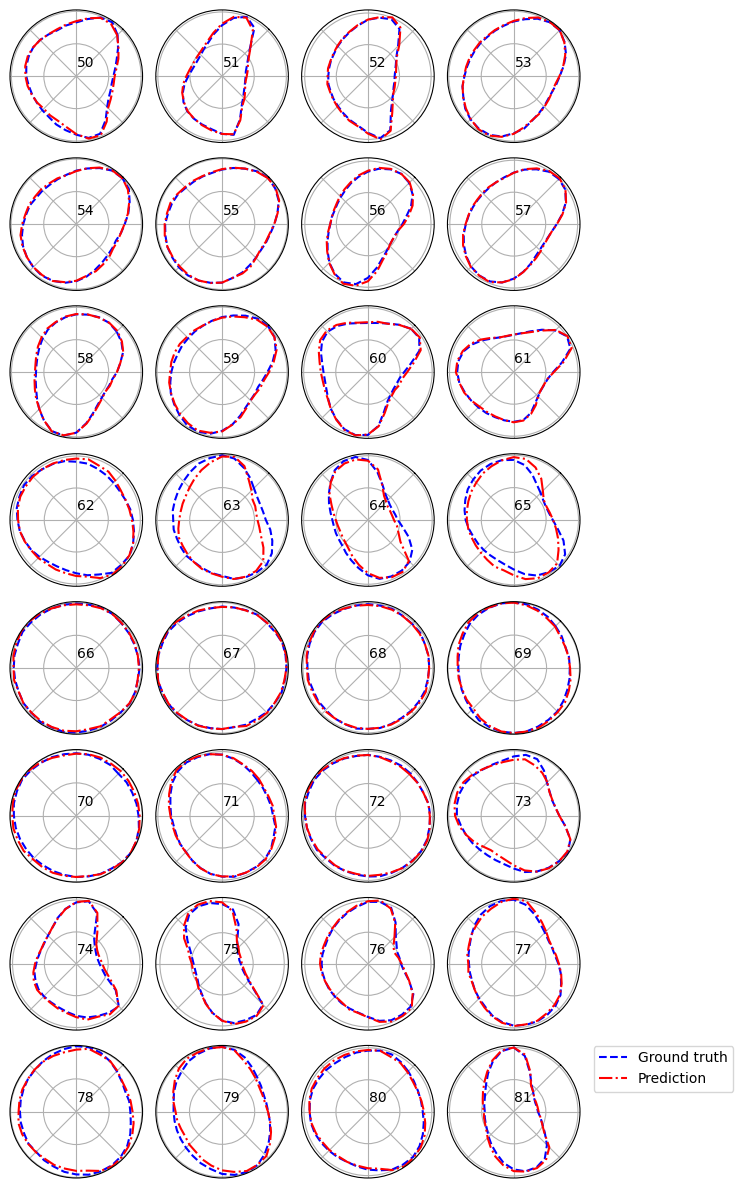

In [37]:
from Plotting_Functions import ComparisonPolarPlot, MultipleComparisonPolarPlots

n_ratios = ratios.shape[-1]
prediction_data = predictions_selected_seq_step_only[:,0:n_ratios]
ground_truth_data = y_train_selected_seq_step_only[:,0:n_ratios]

deg2rad = np.pi/180
theta = np.arange(0,360,360/n_ratios)*deg2rad
ground_truth_for_plotting =  ground_truth_data[:,np.r_[0:n_ratios,0]] 
prediction_for_plotting = prediction_data[:,np.r_[0:n_ratios,0]]

theta_for_plotting = theta[np.r_[0:n_ratios,0]]
MultipleComparisonPolarPlots(theta_for_plotting, ground_truth_for_plotting, 
                             prediction_for_plotting, first_plot_id=50, nrows=8, ncols = 4, hspace=0.1,
                             r_1_legend="Ground truth",r_2_legend="Prediction", zero_location="NE")

In [15]:
prediction = shape_prediction_model(x_data_rearranged)

Validation data test

In [14]:
prediction = shape_prediction_model(x_test)
selected_seq_step = 2 #-1

prediction_numpy = prediction.numpy()
predictions_selected_seq_step_only = prediction_numpy[:,selected_seq_step,:]
y_test_selected_seq_step_only = y_test[:,selected_seq_step,:]

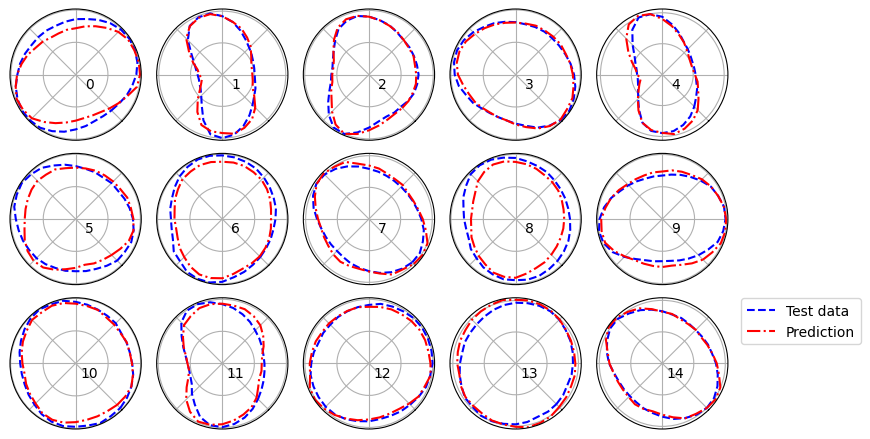

In [15]:
n_ratios = ratios.shape[-1]
prediction_data = predictions_selected_seq_step_only[:,0:n_ratios]
ground_truth_data = y_test_selected_seq_step_only[:,0:n_ratios]


deg2rad = np.pi/180
theta = np.arange(0,360,360/n_ratios)*deg2rad
ground_truth_for_plotting =  ground_truth_data[:,np.r_[0:n_ratios,0]] 
prediction_for_plotting = prediction_data[:,np.r_[0:n_ratios,0]]

theta_for_plotting = theta[np.r_[0:n_ratios,0]]
MultipleComparisonPolarPlots(theta_for_plotting, ground_truth_for_plotting, 
                             prediction_for_plotting, first_plot_id=0, nrows=3, ncols = 5, hspace=0.1,
                             r_1_legend="Test data",r_2_legend="Prediction")

In [21]:
prediction = shape_prediction_model(x_test)
selected_seq_step = 2 #-1

prediction_numpy = prediction.numpy()
predictions_selected_seq_step_only = prediction_numpy[:,selected_seq_step,:]
y_test_selected_seq_step_only = y_test[:,selected_seq_step,:]

In [22]:
predictions_for_all_data = shape_prediction_model(x_data_rearranged)
predictions_for_all_data = predictions_for_all_data.numpy()

In [23]:
img_path_data = exp_data_stacked['file_name_path'].to_numpy()
#img_path_data = np.char.replace(img_path_data.astype(str), '../Experiment Data', 'data')
img_path_data = np.char.replace(img_path_data.astype(str), '../Experiment Data', '../../LS/Experiment Data')

In [24]:
def displayCoilStatus(ax,coilCurrents,coilTipPos,alpha=.3):
  
  indicatorColor = np.zeros((len(coilTipPos),3))
  for i in range(len(coilTipPos)):    
    if coilCurrents[i]>0:
      indicatorColor[i,:] =[0, min([(coilCurrents[i]/max(coilCurrents)), 1]), 0]
    else:
      indicatorColor[i,:] =[1, 0, 0]

    ax.plot(coilTipPos[i,0],coilTipPos[i,1],'o',markersize=12, markerfacecolor=indicatorColor[i,:],markeredgecolor='k', alpha=alpha)

In [25]:
import matplotlib.pyplot as plt
import cv2 as cv

actuator_position = np.array([[635, 350], [680, 525], [635, 690], [474, 750], [300, 700], [235, 535], [280, 350], [474,277]])

Use ground truth cog for predicted shape

In [32]:
from matplotlib.patches import Rectangle

def plotShapePredictionFigure():
    pix2mm = 4/188
    shape_intersection_distances = np.linalg.norm(intersectionPt - cog_data[:, :, np.newaxis, :], axis=-1)
    intersection_distance_max = np.max(shape_intersection_distances,axis=-1)

    pred_radiuses = prediction_numpy[:,:,0:n_ratios]*intersection_distance_max[test_data_idx,:, np.newaxis]
    radiuses = y_data_rearranged[test_data_idx,:,0:n_ratios]*intersection_distance_max[test_data_idx,:, np.newaxis]

    deg2rad = np.pi/180
    phase = 270 - 360/32
    x_pt = ( pred_radiuses * np.sin(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,0, np.newaxis]
    y_pt = ( pred_radiuses * np.cos(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,1, np.newaxis]
    x_pt = x_pt[...,np.r_[0:n_ratios,0]]
    y_pt = y_pt[...,np.r_[0:n_ratios,0]]

    x_pt_true = ( radiuses * np.sin(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,0, np.newaxis]
    y_pt_true = ( radiuses * np.cos(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,1, np.newaxis]
    x_pt_true = x_pt_true[...,np.r_[0:n_ratios,0]]
    y_pt_true = y_pt_true[...,np.r_[0:n_ratios,0]]

    total_sequences = 23
    seq_length = 2
    fig_scale = 3
    fig, axs= plt.subplots(seq_length, total_sequences, figsize=(total_sequences*fig_scale,seq_length*fig_scale))

    spacing = 40
    roi_rect = {'x':230-spacing, 'y':290-spacing, 'w':457+spacing*2, 'h':457+spacing*2}

    actuation = actuation_data[test_data_idx,...]

    for i in range(0,seq_length):
        for j in range(total_sequences):
            im_1 = cv.imread(img_path_data[test_data_idx[j]][i+1])
            axs[i][j].imshow(cv.cvtColor(im_1,cv.COLOR_BGR2RGB))
            displayCoilStatus(axs[i][j],actuation[j,i+1,:], actuator_position, alpha=1)
            axs[i][j].axis([ roi_rect['x'], roi_rect['x'] + roi_rect['w'], roi_rect['y']+roi_rect['h'], roi_rect['y']])
            axs[i][j].add_patch(Rectangle((roi_rect['x']+420, roi_rect['y']+500), 2/pix2mm, 15,
                                facecolor = 'white',
                                fill=True,
                                lw=5))

            axs[i][j].plot(x_pt[j,i+1,:], y_pt[j,i+1,:], 'r--')
            axs[i][j].plot(x_pt_true[j,i+1,:], y_pt_true[j,i+1,:], 'b--')
            axs[i,j].axes.get_xaxis().set_visible(False)
            axs[i,j].axes.get_yaxis().set_visible(False)
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = -0.1, wspace = 0.05)
    #plt.savefig('./MARSS_Paper_Models/LSTM nUnits comparison/'+ str(n_lstm_units) + ' LSTM Units '+ str(n_epoch) + ' epoch ') 

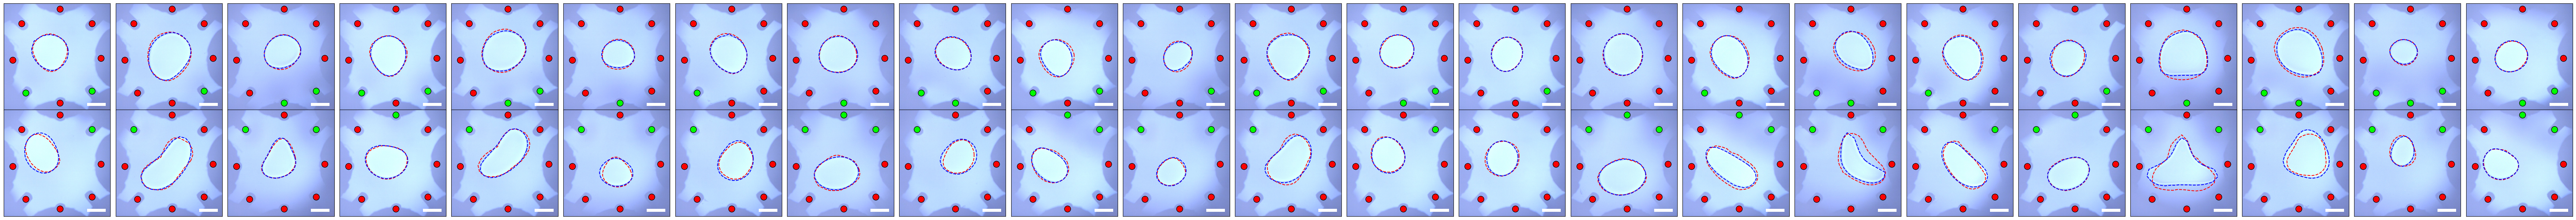

In [33]:
plotShapePredictionFigure()


Plotting shape ratio errors in millimeters

In [29]:
pix2mm = 4/188
shape_intersection_distances = np.linalg.norm(intersectionPt - cog_data[:, :, np.newaxis, :], axis=-1)
intersection_distance_max = np.max(shape_intersection_distances,axis=-1)
intersection_distance_max_mm = intersection_distance_max * pix2mm

pred_radiuses = prediction_numpy[:,:,0:n_ratios]*intersection_distance_max[test_data_idx,:, np.newaxis]
radiuses = y_data_rearranged[test_data_idx,:,0:n_ratios]*intersection_distance_max[test_data_idx,:, np.newaxis]

deg2rad = np.pi/180
phase = 270 - 360/32
x_pt = ( pred_radiuses * np.sin(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,0, np.newaxis]
y_pt = ( pred_radiuses * np.cos(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,1, np.newaxis]

x_pt_true = ( radiuses * np.sin(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,0, np.newaxis]
y_pt_true = ( radiuses * np.cos(-np.arange(phase,360+phase,360/32)*deg2rad) ) + cog_data[test_data_idx,:,1, np.newaxis]

In [30]:
radiuses_mm      = radiuses*pix2mm
pred_radiuses_mm = pred_radiuses*pix2mm

Text(0.5, 0, 'Sequence')

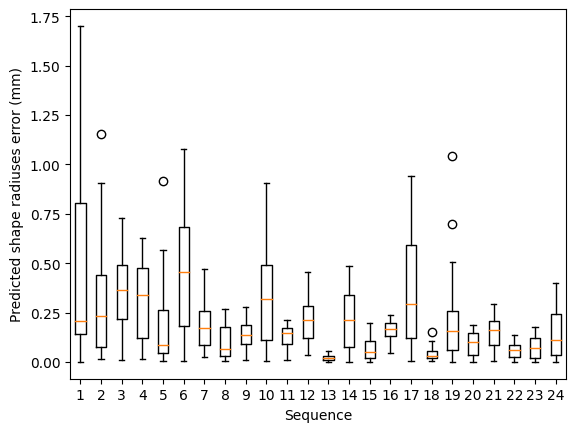

In [32]:
radiuses_error = np.abs(radiuses_mm - pred_radiuses_mm)
plt.boxplot(radiuses_error[:,-1,:].T)
plt.ylabel("Predicted shape radiuses error (mm)")
plt.xlabel("Sequence")

(-0.5, 4.5)

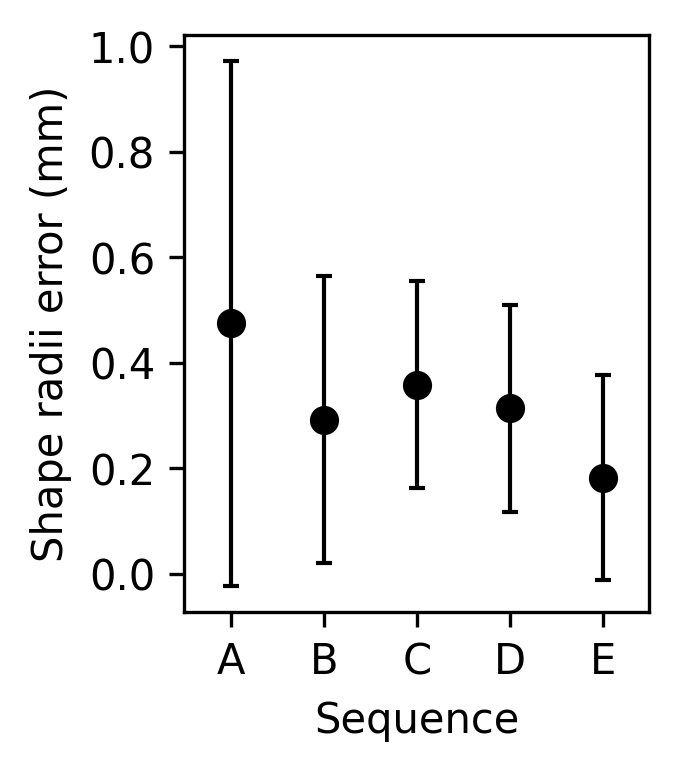

In [35]:
import string
#import matplotlib
import matplotlib.pyplot as plt

#matplotlib.rcParams['figure.dpi'] = 300

selected_seq_step = 2

error_of_selected_step = radiuses_error[:,selected_seq_step,:].T
means = error_of_selected_step.mean(0)
maxs = error_of_selected_step.max(0)
std = error_of_selected_step.std(0)

rangeToPlot = 5
plt.figure(figsize=(2,2.5),dpi=300)
plt.errorbar(list(string.ascii_uppercase)[0:rangeToPlot], means[0:rangeToPlot],std[0:rangeToPlot],fmt='ok', lw=1, capsize=2)
plt.ylabel("Shape radii error (mm)")
plt.xlabel("Sequence")
ax = plt.gca()
ax.set_xlim(-0.5,rangeToPlot-0.5)

In [56]:
means[0:rangeToPlot]


array([0.47479847, 0.29261736, 0.35888654, 0.3140462 , 0.18207903])

In [35]:
std[0:rangeToPlot]

array([0.08616768, 0.09415822, 0.1072928 , 0.09207844, 0.10888838])

In [72]:
pred_radiuses_mm.shape

(24, 3, 32)

In [40]:
max_radii_error_maxIptDist_percentage = maxs/intersection_distance_max_mm[test_data_idx,selected_seq_step]*100
max_radii_error_maxIptDist_percentage


array([13.72498899, 13.6149212 , 13.72166772, 11.13401608, 13.65815602,
       10.03466654, 10.12718661,  8.53806639,  7.35183775,  7.71687531,
        9.32084357, 11.27506249,  8.79620219,  7.93526291,  7.03595648,
       13.66959079, 10.70852169, 10.98150014, 17.41208681,  4.80130337,
        6.20978736,  4.2784937 , 15.27230689, 10.71805917])

In [41]:
np.save('radiuses_mm.npy',radiuses_mm)
np.save('pred_radiuses_mm.npy', pred_radiuses_mm)
np.save('max_radii_error_maxIptDist_percentage.npy', max_radii_error_maxIptDist_percentage)

In [55]:
predicted_contour = np.stack((x_pt,y_pt),-1)
true_contour = np.stack((x_pt_true,y_pt_true),-1)

In [57]:
import scipy.io
scipy.io.savemat('true_contour.mat', mdict={'true_contour': true_contour})
scipy.io.savemat('predicted_contour.mat', mdict={'predicted_contour': predicted_contour})